# LiDAR-based SLAM

Zejia Wu zew024@ucsd.edu

In [1]:
# import the necessary libraries
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
import transforms3d as t3d
import open3d as o3d
import matplotlib.pyplot as plt

from load_data import load_data, data_synch
from motion import encoder_imu_odometry, lidar_scan_matching_odometry
from mapping import lidar2pointcloud, gen_occ_map, dynamic_occ_map, gen_gif
from loop import fixed_interval_graph_slam, proximity_graph_slam
from rgbd_texture import match_rgbd2lidar
from icp import icp
from pr2_utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data

dataset_index = 21

t_start = tic()

encoder_counts, encoder_stamps, lidar_angle_min, lidar_angle_max, \
    lidar_angle_increment, lidar_range_min, lidar_range_max, lidar_ranges, \
        lidar_stamps, imu_angular_velocity, imu_linear_acceleration, imu_stamps, \
            disp_stamps, rgb_stamps = load_data(dataset_index)

toc(t_start, "Data loading")

[Info] Encoder data loaded: 
* Encoder counts shape:  (4, 4789)
* Encoder stamps shape:  (4789,)
**************************************************
[Info] Hokuyo data loaded: 
* Lidar angle min:  -2.356194490192345
* Lidar angle max:  2.356194490192345
* Lidar angle increment:  [[0.00436332]]
* Lidar range min:  0.1
* Lidar range max:  30
* Lidar ranges shape:  (1081, 4785)
* Lidar stamps shape:  (4785,)
**************************************************
[Info] Imu data loaded: 
* Imu angular velocity shape:  (3, 11730)
* Imu linear acceleration shape:  (3, 11730)
* Imu stamps shape:  (11730,)
**************************************************
[Info] Kinect data loaded: 
* Disparity stamps shape:  (2188,)
* Rgb stamps shape:  (2112,)
**************************************************
Data loading took: 0.08681893348693848 sec.



## encoder-imu odometry

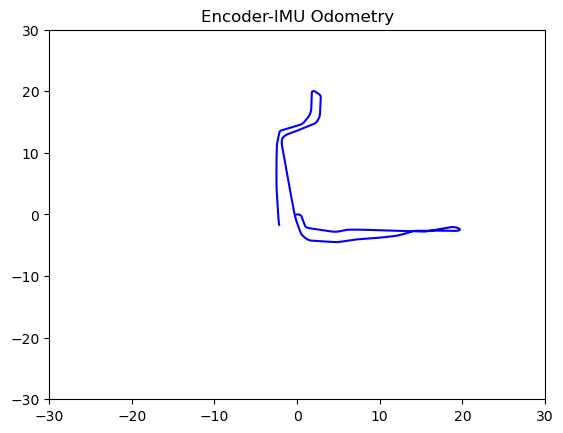

Encoder-IMU Odometry took: 0.23687195777893066 sec.



In [3]:
t_start = tic()
# odometry using encoder counts and IMU angular velocity
synched_encoder_stamps_2lidar, synched_encoder_counts_2lidar = data_synch(lidar_stamps[1:], encoder_stamps, encoder_counts)
synched_encoder_counts_2lidar = np.hstack((np.array([[0], [0], [0], [0]], dtype=np.int16),synched_encoder_counts_2lidar))
encoder_imu_odom_poses = encoder_imu_odometry(synched_encoder_counts_2lidar, imu_angular_velocity, lidar_stamps, imu_stamps)
# visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(encoder_imu_odom_poses[:, 0, 2], encoder_imu_odom_poses[:, 1, 2], 'b-')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
ax.title.set_text('Encoder-IMU Odometry')
plt.savefig(f'../figures/encoder_imu_odometry_{dataset_index}.png')
plt.show()
toc(t_start, "Encoder-IMU Odometry")

100%|██████████| 240/240 [00:05<00:00, 45.59it/s]


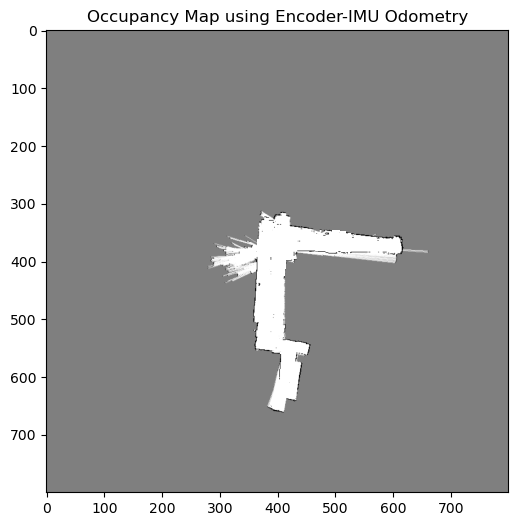

Occupancy Map using Encoder-IMU Odometry took: 5.474215745925903 sec.



In [4]:
# generate the occupancy map using the encoder-imu odometry and the lidar points
t_start = tic()
lidar_points = lidar2pointcloud(lidar_ranges, lidar_angle_min, lidar_angle_increment, \
                                lidar_range_min = 0.1, lidar_range_max = 30.0)
occ_prob_map = gen_occ_map(encoder_imu_odom_poses, lidar_points, width=800, resolution=0.1)

plt.figure(figsize=(6, 6))
plt.imshow(occ_prob_map, cmap='gray_r')
plt.title('Occupancy Map using Encoder-IMU Odometry')
plt.savefig(f'../figures/encoder_imu_odometry_occ_map_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map using Encoder-IMU Odometry")

## LiDAR Scan Matching

### Without Encoder-IMU Odometry as Initial Guess

In [5]:
# generate the robot trajectory without encoder-imu odometry as initial guess
t_start = tic()
lidar_scan_matching_odom_poses_nig = lidar_scan_matching_odometry(lidar_points, encoder_imu_odom_poses=None)
toc(t_start, "LiDAR Scan Matching Odometry (no initial guess)")

LiDAR Scan Matching Odometry (no initial guess) took: 130.68970799446106 sec.



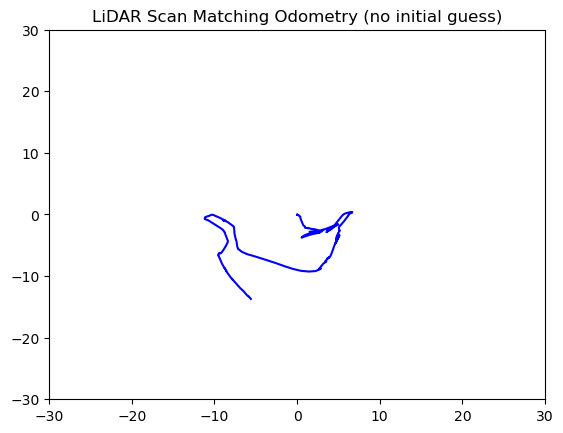

In [6]:
# visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lidar_scan_matching_odom_poses_nig[:, 0, 2], lidar_scan_matching_odom_poses_nig[:, 1, 2], 'b-')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
ax.title.set_text('LiDAR Scan Matching Odometry (no initial guess)')
plt.savefig(f'../figures/lidar_scan_matching_odometry_no_initial_guess_{dataset_index}.png')
plt.show()

100%|██████████| 240/240 [00:05<00:00, 44.65it/s]


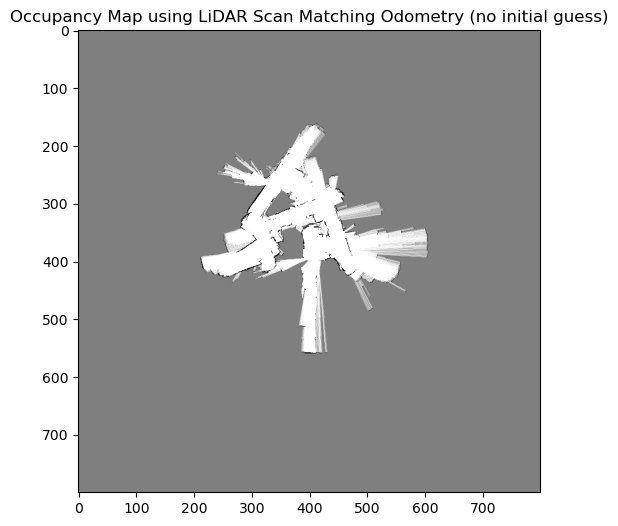

Occupancy Map using LiDAR Scan Matching Odometry (no initial guess) took: 5.487565994262695 sec.



In [7]:
# generate the occupancy map using the LiDAR scan matching odometry and the lidar points
# without encoder-imu odometry as initial guess
t_start = tic()
occ_prob_map_scan_matching_nig = gen_occ_map(lidar_scan_matching_odom_poses_nig, lidar_points, width=800, resolution=0.1)

plt.figure(figsize=(6, 6))
plt.imshow(occ_prob_map_scan_matching_nig, cmap='gray_r')
plt.title('Occupancy Map using LiDAR Scan Matching Odometry (no initial guess)')
plt.savefig(f'../figures/lidar_scan_matching_odometry_occ_map_no_initial_guess_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map using LiDAR Scan Matching Odometry (no initial guess)")

## With Encoder-IMU Odometry as Initial Guess

In [8]:
# generate the robot trajectory with encoder-imu odometry as initial guess
t_start = tic()
lidar_scan_matching_odom_poses = lidar_scan_matching_odometry(lidar_points, encoder_imu_odom_poses=encoder_imu_odom_poses)
toc(t_start, "LiDAR Scan Matching Odometry (with initial guess)")

LiDAR Scan Matching Odometry (with initial guess) took: 100.17472004890442 sec.



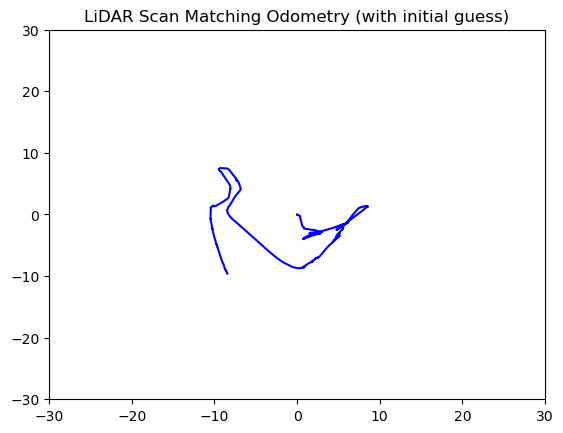

In [9]:
# visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lidar_scan_matching_odom_poses[:, 0, 2], lidar_scan_matching_odom_poses[:, 1, 2], 'b-')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
ax.title.set_text('LiDAR Scan Matching Odometry (with initial guess)')
plt.savefig(f'../figures/lidar_scan_matching_odometry_with_initial_guess_{dataset_index}.png')
plt.show()

100%|██████████| 240/240 [00:05<00:00, 43.89it/s]


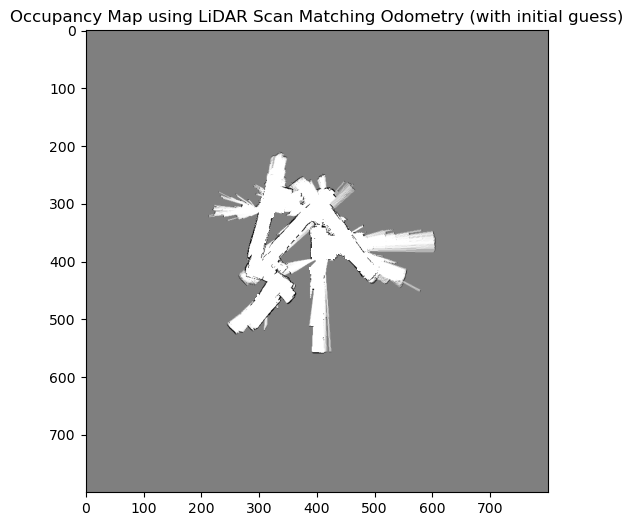

Occupancy Map using LiDAR Scan Matching Odometry (with initial guess) took: 5.580425024032593 sec.



In [10]:
# generate the occupancy map using the LiDAR scan matching odometry and the lidar points
# with encoder-imu odometry as initial guess
t_start = tic()
occ_prob_map_scan_matching = gen_occ_map(lidar_scan_matching_odom_poses, lidar_points, width=800, resolution=0.1)

plt.figure(figsize=(6, 6))
plt.imshow(occ_prob_map_scan_matching, cmap='gray_r')
plt.title('Occupancy Map using LiDAR Scan Matching Odometry (with initial guess)')
plt.savefig(f'../figures/lidar_scan_matching_odometry_occ_map_with_initial_guess_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map using LiDAR Scan Matching Odometry (with initial guess)")

## Closed-Loop Graph SLAM
### Fixed-Interval Graph SLAM

In [11]:
# generate the robot trajectory using fixed-interval graph slam
t_start = tic()
closed_loop_fi_odom_poses = fixed_interval_graph_slam(encoder_imu_odom_poses, lidar_points, interval=10)
toc(t_start, "Closed-Loop Fixed-Interval Graph SLAM")

  0%|          | 0/4784 [00:00<?, ?it/s]

100%|██████████| 4784/4784 [02:01<00:00, 39.38it/s]


Closed-Loop Fixed-Interval Graph SLAM took: 121.64547109603882 sec.



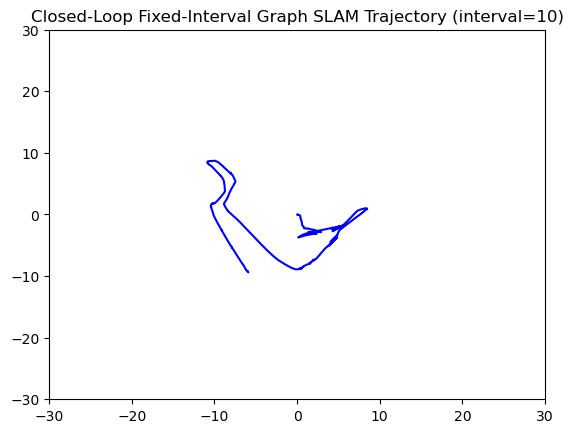

In [12]:
# visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(closed_loop_fi_odom_poses[:, 0, 2], closed_loop_fi_odom_poses[:, 1, 2], 'b-')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
ax.title.set_text('Closed-Loop Fixed-Interval Graph SLAM Trajectory (interval=10)')
plt.savefig(f'../figures/closed_loop_fixed_interval_graph_slam_interval_10_{dataset_index}.png')
plt.show()

100%|██████████| 240/240 [00:05<00:00, 42.94it/s]


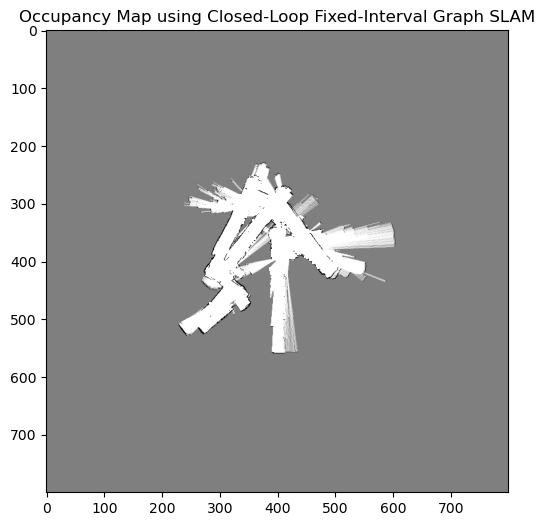

Occupancy Map using Closed-Loop Fixed-Interval Graph SLAM took: 5.696685075759888 sec.



In [13]:
# generate the occupancy map using closed-loop fixed-interval graph slam
t_start = tic()
occ_prob_map_closed_loop_fi = gen_occ_map(closed_loop_fi_odom_poses, lidar_points, width=800, resolution=0.1)

plt.figure(figsize=(6, 6))
plt.imshow(occ_prob_map_closed_loop_fi, cmap='gray_r')
plt.title('Occupancy Map using Closed-Loop Fixed-Interval Graph SLAM')
plt.savefig(f'../figures/closed_loop_fixed_interval_graph_slam_occ_map_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map using Closed-Loop Fixed-Interval Graph SLAM")

## Proximity-Based Graph SLAM

In [14]:
# generate the robot trajectory using proximity-based graph slam
t_start = tic()
closed_loop_pb_odom_poses = proximity_graph_slam(encoder_imu_odom_poses, lidar_points, fixed_closure_interval=30, \
                                                 proximity_closure_interval=100, proximity_closure_step=800, \
                                                 optimization_interval=1000, proximity_threshold=0.2)
toc(t_start, "Closed-Loop Proximity-Based Graph SLAM")

  0%|          | 0/4784 [00:00<?, ?it/s]

 17%|█▋        | 795/4784 [00:11<01:27, 45.78it/s] 

[Info] Optimization at iteration 784


 37%|███▋      | 1788/4784 [00:38<01:17, 38.60it/s]

[Info] Optimization at iteration 1784


 58%|█████▊    | 2784/4784 [01:04<01:05, 30.42it/s]

[Info] Optimization at iteration 2784


 79%|███████▉  | 3785/4784 [01:28<00:33, 29.84it/s]

[Info] Optimization at iteration 3784


 80%|███████▉  | 3807/4784 [01:28<00:20, 46.61it/s]

[Info] Loop closure factor between 3000 and 3800 added.


100%|██████████| 4784/4784 [01:50<00:00, 43.34it/s]

[Info] Optimization at iteration 4784


Closed-Loop Proximity-Based Graph SLAM took: 110.60004997253418 sec.



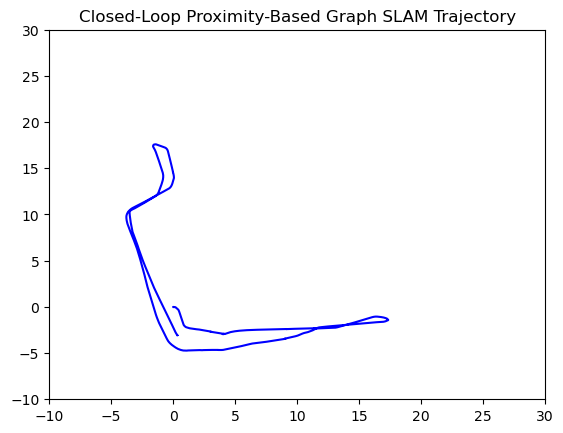

In [15]:
# visualize the trajectory
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(closed_loop_pb_odom_poses[:, 0, 2], closed_loop_pb_odom_poses[:, 1, 2], 'b-')
plt.xlim(-10, 30)
plt.ylim(-10, 30)
ax.title.set_text('Closed-Loop Proximity-Based Graph SLAM Trajectory')
plt.savefig(f'../figures/closed_loop_proximity_based_graph_slam_trajectory_{dataset_index}.png')
plt.show()

100%|██████████| 240/240 [00:05<00:00, 43.52it/s]


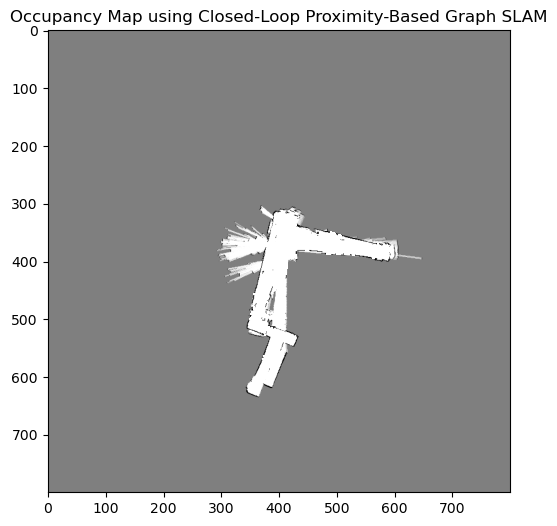

Occupancy Map using Closed-Loop Proximity-Based Graph SLAM took: 5.622802019119263 sec.



In [16]:
# generate the occupancy map using closed-loop fixed-interval graph slam
t_start = tic()
occ_prob_map_closed_loop_pb = gen_occ_map(closed_loop_pb_odom_poses, lidar_points, width=800, resolution=0.1)

plt.figure(figsize=(6, 6))
plt.imshow(occ_prob_map_closed_loop_pb, cmap='gray_r')
plt.title('Occupancy Map using Closed-Loop Proximity-Based Graph SLAM')
plt.savefig(f'../figures/closed_loop_proximity_based_graph_slam_occ_map_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map using Closed-Loop Proximity-Based Graph SLAM")

## Texture Mapping

In [17]:
t_start = tic()
aligned_ground_pointcloud, aligned_rgb_pointcloud = match_rgbd2lidar(lidar_stamps, disp_stamps, rgb_stamps, dataset_index)
toc(t_start, "Matching RGBD to LiDAR")

(2095,) (2095,) (2095,)


100%|██████████| 419/419 [01:12<00:00,  5.75it/s]

Matching RGBD to LiDAR took: 72.95743179321289 sec.



100%|██████████| 4784/4784 [02:48<00:00, 28.41it/s]


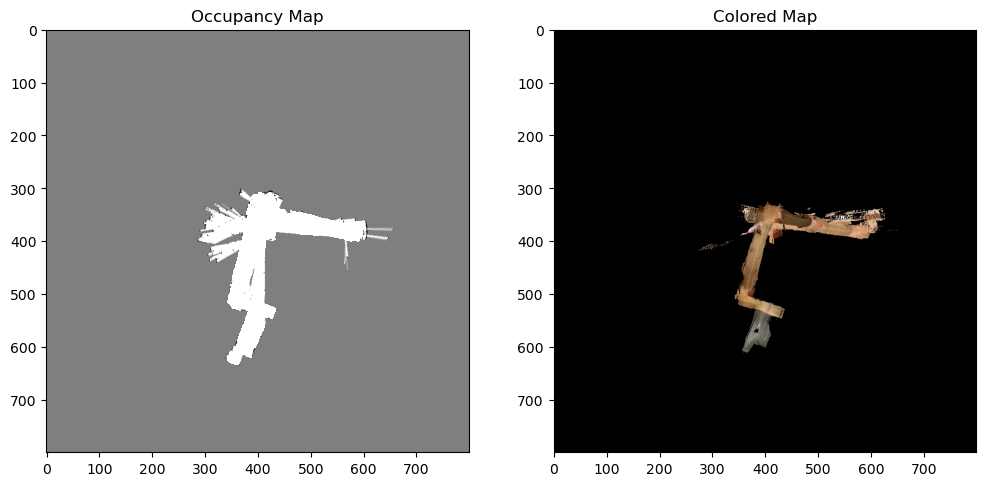

Occupancy Map and Colored Map using Closed-Loop Proximity-Based Graph SLAM took: 168.6036238670349 sec.



In [18]:
# generate the occupancy map and colored map using closed-loop fixed-interval graph slam
t_start = tic()
occ_prob_map_closed_loop_pb, colored_map_closed_loop_pb = gen_occ_map( \
    closed_loop_pb_odom_poses, lidar_points, \
        width=800, resolution=0.1, \
            aligned_ground_pointcloud=aligned_ground_pointcloud, interval=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(occ_prob_map_closed_loop_pb, cmap='gray_r')
plt.title('Occupancy Map')
plt.subplot(1, 2, 2)
plt.imshow(colored_map_closed_loop_pb)
plt.title('Colored Map')
plt.savefig(f'../figures/closed_loop_proximity_based_graph_slam_occ_map_colored_map_{dataset_index}.png')
plt.show()
toc(t_start, "Occupancy Map and Colored Map using Closed-Loop Proximity-Based Graph SLAM")

In [19]:
combined_img_path = f'../data/dynamic_occ_map/dataset{dataset_index}'
dynamic_occ_map(closed_loop_pb_odom_poses, lidar_points, width=800, resolution=0.1, aligned_ground_pointcloud=aligned_ground_pointcloud, interval=1, save_path=combined_img_path)

100%|██████████| 4185/4185 [04:15<00:00, 16.36it/s]


In [20]:
gif_path = f'../assets/map_combined_{dataset_index}'
gen_gif(combined_img_path, gif_path)